# K-means Clustering and Principal Component Analysis
在本练习中，我们将实现K-means聚类算法，并使用它来压缩图像。我们还将使用主成分分析来找到面部图像的低维表示。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat

## 1. K-means Clustering

### Visualizing data

(300, 2)


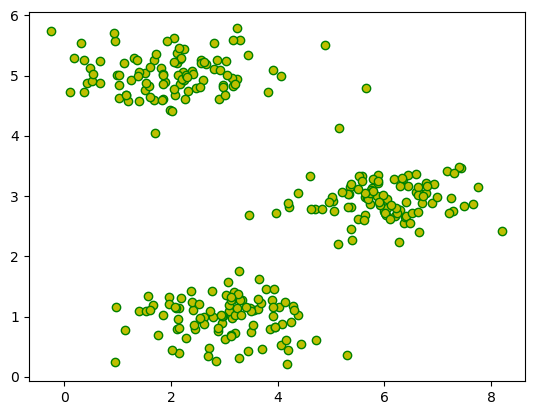

In [2]:
data = loadmat('data/ex7data2.mat')
X = data['X']
print(X.shape)
plt.scatter(X[:,0],X[:,1],label = 'train',marker='o', c='y', edgecolors='g')
plt.show()

### Implementing K-means
- **finding closest centroids**
<img src = "pic/centroid.jpg" width = 300>
- **Computing centroid means**
<img src = "pic/centroid_mean.jpg" width = 140>

In [3]:
# 从训练样例里面随机选取k个点作为初始中心点
def random_init(X, k):
    sample_idxs = [i for i in range(len(X))]
    sample_idxs = random.sample(sample_idxs, k)
    centroids = X[sample_idxs, :]
    return centroids

In [4]:
def find_closest_centroids(X, centroids):
    idx = [] # 最接近x的centroid的索引
    for i in range(len(X)):
        dist = np.linalg.norm(X[i]-centroids,axis = 1)
        idx.append(np.argmin(dist))
    
    return np.array(idx)

In [5]:
def compute_centroids(X, idx, k): 
    new_centroids = []
    for i in range(k):
        centroid = np.mean(X[idx == i], axis = 0)
        new_centroids.append(centroid)
    
    return np.array(new_centroids)

In [6]:
def run_kmeans(X, k, iters):
    centroids = random_init(X, k)
    centroids_all = []
    for i in range(iters):
        centroids_all.append(centroids)
        idx = find_closest_centroids(X, centroids)       
        centroids = compute_centroids(X, idx, k)
    
    return idx, np.array(centroids_all)

In [7]:
idx, centroids_all = run_kmeans(X, k = 3, iters = 200)

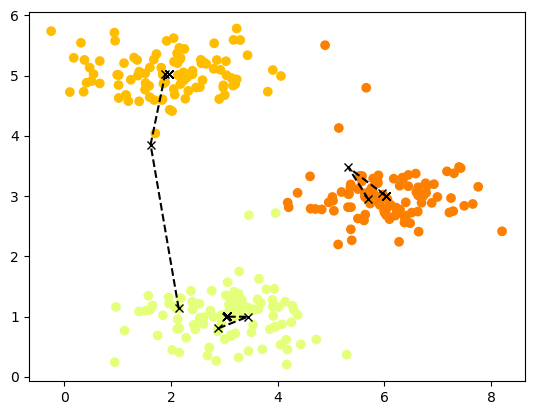

In [8]:
#绘制数据集和聚类中心的移动轨迹
def plot_data1(X, centroids_all, idx):
    plt.figure()
    plt.scatter(X[:,0],X[:,1], c= idx, cmap = 'Wistia')#数据集颜色根据x类别来区分
    plt.plot(centroids_all[:,:,0], centroids_all[:,:,1], 'kx--')
 
plot_data1(X, centroids_all, idx)

### Image compression with K-means
- 把图像所包含的数千种颜色减少到具有代表性的16种。  
- 通过压缩，可以以有效的方式表示压缩照片。你只需要存储16种选定颜色的RGB值，然后对于图像中的每个像素，就只需要存储该位置的颜色索引，而我们仅需要4个比特来表示16种可能性，即图像本身每个像素位置只需要4位。  
- 所以，在这个练习中，你需要使用K-means算法来选出这16种颜色。

In [9]:
from skimage import io

pic = io.imread('data/bird_small.png') / 255

In [10]:
pic_flatten = pic.reshape(-1, 3) # 16384 * 3
k = 16
idx, colors_all = run_kmeans(pic_flatten, k, iters = 20)

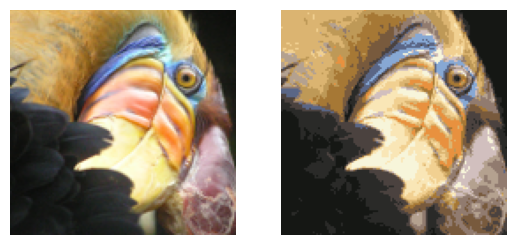

In [11]:
colors = colors_all[-1] # 取迭代完的最后一个
compressed_pic = np.zeros(pic_flatten.shape)

for i in range(k):
    compressed_pic[idx == i] = colors[i]

compressed_pic = compressed_pic.reshape(128,128,3)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

## 2. Principal Component Analysis
使用主成分分析（PCA）来执行降维.

### Visualizing data

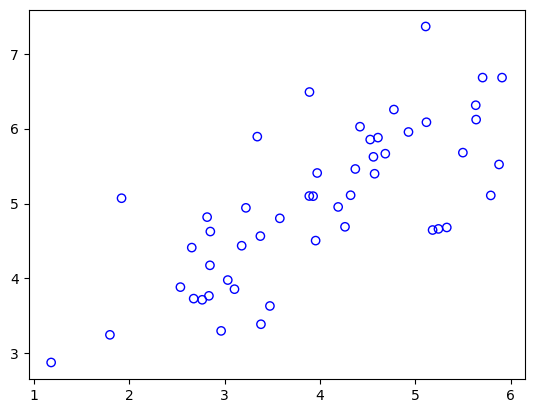

In [12]:
data = loadmat('data/ex7data1.mat')
X = data['X']
# X.shape
plt.scatter(X[:,0],X[:,1],label = 'train',marker='o', c='none', edgecolors='b')
plt.show()

### Implementing PCA

In [13]:
def normalize(X):
    return (X - X.mean(axis = 0)) / X.std(axis = 0, ddof = 1)

In [14]:
def pca(X_norm):
    # compute the covariance matrix
    cov = (X_norm.T @ X_norm) / len(X_norm)
    # perform SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

Text(0.5, 1.0, 'Computed eigenvectors of the datase')

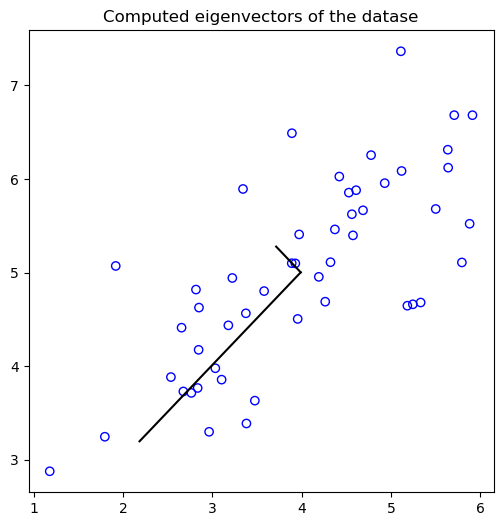

In [15]:
X_norm = normalize(X)
U, S, V = pca(X_norm)

mu = X.mean(axis = 0)
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], marker='o', facecolors='none', edgecolors='b')
plt.plot([mu[0], mu[0]+1.5*S[0]*U[0,0]], [mu[1], mu[1]+1.5*S[0]*U[1,0]], 'k') #两个点的连线
plt.plot([mu[0], mu[0]+1.5*S[1]*U[0,1]], [mu[1], mu[1]+1.5*S[1]*U[1,1]], 'k') #这里的1.5和S表示特征向量的
plt.title('Computed eigenvectors of the datase')

### Dimensionality Reduction with PCA

In [16]:
def project_data(X_norm, U, k):
    if k > X_norm.shape[1]:
        raise ValueError('k should be lower dimension of n')
    
    return X_norm @ U[:, 0:k]

In [17]:
Z = project_data(X_norm, U, 1)
Z.shape, Z[0]

((50, 1), array([1.48127391]))

In [18]:
def recover_data(Z, U):
    k = Z.shape[1]
    if k >= U.shape[0]:
        raise ValueError('Z dimension is upper than U, you should recover lower dimension to higher')
    
    return Z @ U[:, 0:k].T

In [19]:
X_rec = recover_data(Z, U)
X_rec[0]

array([-1.04741883, -1.04741883])

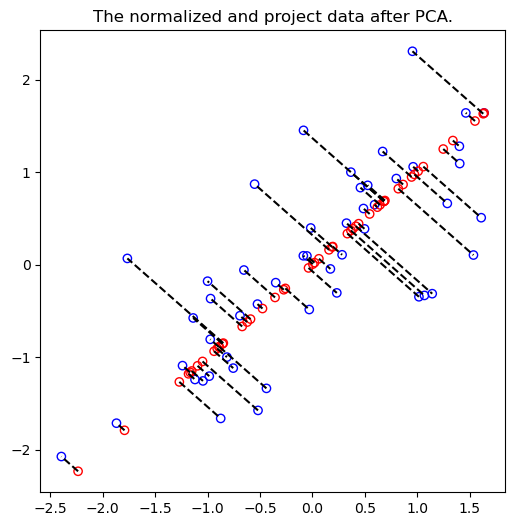

In [20]:
plt.figure(figsize=(6, 6))
plt.title('The normalized and project data after PCA.')

plt.scatter(X_norm[:, 0], X_norm[:, 1], c='none', edgecolors='b')
plt.scatter(X_rec[:, 0], X_rec[:, 1], c='none', edgecolors='r')
plt.plot([X_rec[:,0], X_norm[:,0]], [X_rec[:,1], X_norm[:,1]], 'k--')

plt.show()

### Face Image Dataset
在练习的这一部分中，你将对人脸图像运行主成分分析，以了解如何在实践中使用主成分分析进行降维。

In [21]:
def plot_pics(pic, k):
    fig ,axes = plt.subplots(k, k)
    for i in range(k):
        for j in range(k):
            idx = i * k + j
            a = pic[idx]
            a.shape = 32, 32
            axes[i][j].imshow(a.T, cmap = 'gray')
            axes[i][j].axis('off')
    plt.show()

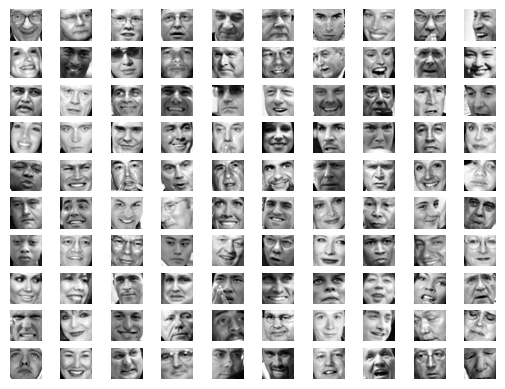

In [22]:
faces_data = loadmat('data/ex7faces.mat')
# faces_data.keys()
faces_pic = faces_data['X']
plot_pics(faces_pic, 10)

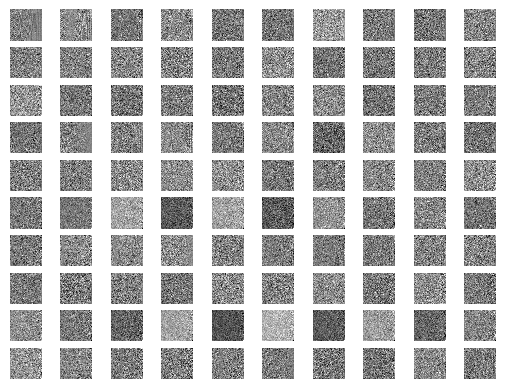

In [23]:
data_norm = normalize(faces_pic)
U, S, V = pca(data_norm)
plot_pics(U, 10)

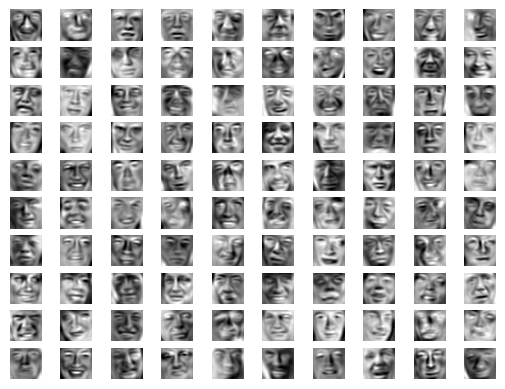

In [25]:
data_proj = project_data(data_norm, U, 100)
data_rec = recover_data(data_proj, U)
plot_pics(data_rec, 10)